### This notebook provdes software supports for the paper :(https://arxiv.org/abs/2505.23373)
In this notebook, you will find how to construct the VQA framework for solving the quantum optimal control problems: the time-minimum control of perfect state transfer in 1d spin chain.
Moreover, we have introduced a new metric, namely, optimility, for quantifying the overall performance of the VQA application. 

The python packages are included in file packages.txt.

In [3]:
import matplotlib.pyplot as plt
from mindquantum.core.gates import X, RZ, RotPauliString,Measure,RX,CNOT
from scipy.spatial import distance
import numpy as np
from scipy.optimize import minimize, Bounds
import scipy
from joblib import Parallel,delayed
from qutip import basis, tensor, Qobj, fidelity


In [4]:
#from functions import * # loading useful functions 
from ansatzs import ansatz ## Find the circuit construction in ansatzs.py.


In [5]:
# 给定优化问题（N，Nt,T 预先给定）输出完整线路
N, T, Nt = 5, 4,10
Ansa = ansatz(N, T, Nt) 
di, df, dt = Ansa.di, Ansa.df,  Ansa.dt
x0 = di + np.random.random(Nt) * (2 * df) - df 
print(x0)
loss, psi= Ansa.correlated_I(x0)
x10= np.random.random(size=(1, 2*N*Nt))[0] * 4 * np.pi
# loss, psi= Ansa.hardware_efficient(x10)
print(Ansa.qc)


[-3.39706907  2.34623352  3.5055222   0.1282863   3.74084571 -3.31325621
  1.79688307  0.50433455  2.25632521 -1.91367651]
      ┏━━━┓ ┏━━━━━━━━━━━━━━┓ ┏━━━━━━━━━━━━━━┓                                     
q0: ──┨╺╋╸┠─┨              ┠─┨              ┠───────────────────────────────────[red bold]↯[/]─
      ┗━━━┛ ┃              ┃ ┃              ┃                                     
            ┃ RPS(-0.4444) ┃ ┃ RPS(-0.4444) ┃ ┏━━━━━━━━━━━━━━┓ ┏━━━━━━━━━━━━━━┓   
q1: ────────┨              ┠─┨              ┠─┨              ┠─┨              ┠─[red bold]↯[/]─
            ┗━━━━━━━━━━━━━━┛ ┗━━━━━━━━━━━━━━┛ ┃              ┃ ┃              ┃   
                                              ┃ RPS(-0.4444) ┃ ┃ RPS(-0.4444) ┃   
q2: ──────────────────────────────────────────┨              ┠─┨              ┠─[red bold]↯[/]─
                                              ┗━━━━━━━━━━━━━━┛ ┗━━━━━━━━━━━━━━┛   
                                                                                  
q3: ────

In [6]:
### define the loss function for three ansata
def loss_fun_correlated_ans(x0, Ansa):
    # for ansatz-a
    global losslist0, x0list0
    loss, psi = Ansa.correlated_I(x0)
    losslist0.append(loss)
    x0list0.append(x0)
    return loss

def loss_fun_correlated_ans1(x0, Ansa):
    # for ansatz-b
    # input the initial guess and return the loss value
    global losslist1, x0list1
    loss, _ = Ansa.correlated_II(x0)
    losslist1.append(loss)
    x0list1.append(x0)
    return loss

def loss_fun_uncorrelated_ans(x0, Ansa):
    # for ansatz-c
    global losslist2, x0list2
    loss, psi = Ansa.uncorrelated(x0)
    losslist2.append(loss)
    x0list2.append(x0)
    return loss

def get_result(Nt, T, N,maxit,only_c=None):
    '''
    this function produce the fidlity for calculating both expressibility and optimality
    import:
    Trotter step: Nt, total time: T, and qubit number :N
    return:
    two group of fidelity (for 3 ansatz):
    [F_1,F_2,F_3]: the fidelity of optimized controller from the initial gauss
    '''
    
    Ansa = ansatz(N, T, Nt)  # ansatz class
 
    #print(psi0)
    di, df, dt = Ansa.di, Ansa.df,  Ansa.dt # given setup
    # optimizer setup in scipy library (see the following scipy.minimize() function)
    optimizer = 'SLSQP'  #'COBYLA'#
    #print(Nt)

    if Nt>50:
        tl = 1e-3 #
        maxit = 100
    else:
        tl = 1e-3 #
        maxit = 100 #
    if only_c is None:
        '''
        The ansatz-A
        '''
        lossfun = loss_fun_correlated_ans   
        x10 = di + np.random.random(Nt) * (2 * df) - df 
        #x10= np.random.random(size=(1, Nt))[0] * 4 * np.pi 
        result1 = minimize(lossfun, x0=x10, args=(Ansa), method=optimizer, options={'maxiter': maxit},tol=tl )  # ,options={'maxiter': maxit},'eps': 1.0,callback=callbackF1,constraints=linear_constraint0,
        x1 = result1.x 
        F_1 = 1 - lossfun(x1, Ansa)   
        '''
        The ansatz-B
        '''
        lossfun2 = loss_fun_correlated_ans1
        x10 = di + np.random.random(Nt) * (2 * df) - df
        #x10= np.random.random(size=(1, Nt))[0] * 4 * np.pi
        x20 = []  # input should be a 1D array
        for ii in range(2 * Nt):
            if ii < Nt:
                x20.append(x10[ii])  # dlist\in [-df,df] np.random.random(1) * 2 * df - df
            else:
                x20.append(np.random.random(1)[0])  ##Clist\in [0,1]
        
        result2 = minimize(lossfun2, x0=x20, args=(Ansa), method=optimizer, options={'maxiter': maxit},tol=tl)  # ,options={'maxiter': maxit},'eps': 1.0,callback=callbackF1,constraints=linear_constraint0,
        x2 = result2.x 
        F_2 = 1 - lossfun2(x2, Ansa)  # 1-10 ** (lossfun2(x2,Ansa))  # 1 - lossfun2(x2,Ansa)  #
    else:
        F_1,F_2 = 0,0
    '''
     The ansatz-C
    '''

    lossfun3 = loss_fun_uncorrelated_ans
    x30 = np.random.random(size=(1, Nt * N))[0] * 4 * np.pi*dt  # -2*np.pi#np.random.random_sample(Nt*N)*2*np.pi
    result3 = minimize(lossfun3, x0=x30, args=(Ansa), method=optimizer, options={'maxiter': maxit},tol=tl)  # ,options={'maxiter': maxit},'eps': 1.0,callback=callbackF1,constraints=linear_constraint0,
    x3 = result3.x 
    F_3 = 1 - lossfun3(x3, Ansa)  ##1-10 ** (lossfun3(x3,Ansa))  #

    return [F_1, F_2, F_3]  

#### Get the final states using VQA framework.
For given Trotter step: Nt, total time:T and qubit number:N, the following block return the loss value (infidelity) for three ansata.

[0.7408091148589435, 0.9981670146269566, 0.9985754597248729]


Text(0, 0.5, 'loss(1-F)')

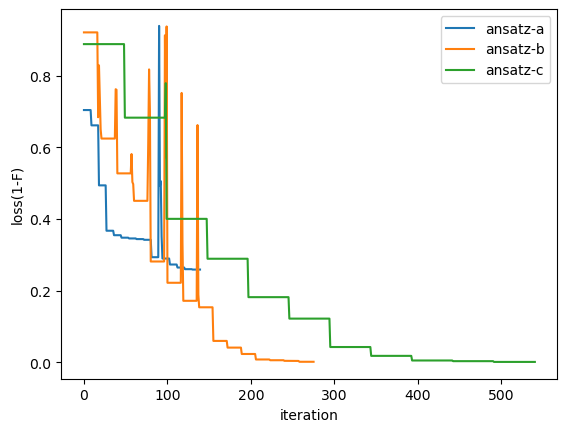

In [7]:
global losslist0, losslist1,losslist2,x0list0,x0list1,x0list2
losslist0,losslist1,losslist2 = [],[],[]
x0list0,x0list1,x0list2= [],[],[]
Nt,T,N,maxit = 8,4,6,10
Flist = get_result(Nt, T, N,maxit)

print(Flist)
plt.plot(losslist0,label='ansatz-a')
plt.plot(losslist1,label='ansatz-b')
plt.plot(losslist2,label='ansatz-c')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss(1-F)')

### The wasserstein distance for VQAs.
The discrete 1-Wasserstein distance (or Earth Mover's Distance) between two discrete probability distributions $ P = \{p_i\}_{i=1}^n $ and $ Q = \{q_j\}_{j=1}^m $ defined over a finite metric space $ {X} = \{x_1, x_2, \dots, x_n\} $ can be expressed as: 
	 
$W_1[P, Q] = \min_{\gamma \in \Gamma(P, Q)} \sum_{i=1}^n \sum_{j=1}^m \gamma_{ij} ~d(x_i, x_j),$

where $ \gamma = \{\gamma_{ij}\} $  is a transportation plan, $\gamma_{ij}$ represents the amount of  "mass" transported from $ x_i $ in distribution   P   to $ x_j $ in distribution   Q . 
$\Gamma(P,Q)$ is the set of all possible transportation plans, subject to the constraints: $\sum_{j=1}^{m}\gamma_{ij}=p_i$ and $\sum_{i=1}^{n}\gamma_{ij}=q_j$ with $\gamma_{ij}\ge 0 $ remains.
The discrete 1-Wasserstein distance represents the minimum total ``cost" of transporting the distribution \( P \) to the distribution   Q  , where the cost is given by the distance $d(x_i, x_j)$ between points $ x_i$ and $ x_j $, weighted by the amount of mass $\gamma_{ij}$ transported.  

### Estimation on W1 distance

In [8]:
def wasserstein_distance_1d(x, p, q):
    """
    Compute the 1-Wasserstein distance (Earth Mover's Distance) between two discrete probability
    distributions on a one-dimensional, sorted support.

    Parameters:
    -----------
    x : array-like
        Sorted support points (in increasing order).
    p : array-like
        Probabilities for the first distribution (must sum to 1).
    q : array-like
        Probabilities for the second distribution (must sum to 1).

    Returns:
    --------
    float
        The 1-Wasserstein distance.
    """
    x = np.asarray(x)
    p = np.asarray(p)
    q = np.asarray(q)

    # Compute the cumulative distribution functions
    F_p = np.cumsum(p)
    F_q = np.cumsum(q)

    # Compute differences between successive support points
    dx = np.diff(x)

    # The 1-Wasserstein distance is given by summing the absolute differences
    # between the CDFs over the intervals.
    distance = np.sum(np.abs(F_p[:-1] - F_q[:-1]) * dx)
    return float(distance)

qubit num N: 6 total time T: 2.5 Trotter step Nt: 5
The Wasserstein distance: 0.9422222222222224
The Wasserstein distance: 0.8085858585858586
The Wasserstein distance: 0.43898989898989904


Text(0, 0.5, 'probablity')

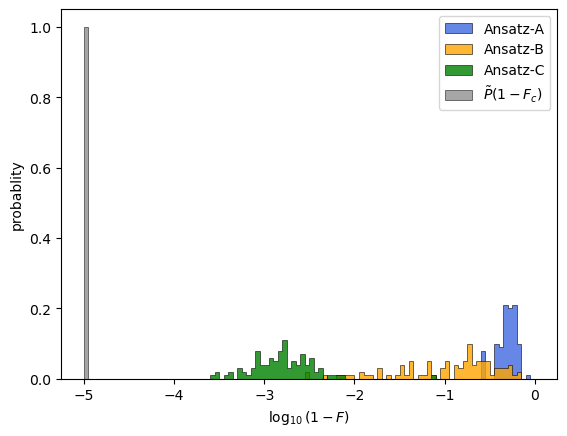

In [9]:
# We take N=6 as an example
N,h,maxit = 6,0.5,5
Flist=[]

T,Nt = (N-1)*h,N-1
print('qubit num N:',N,'total time T:',T,'Trotter step Nt:',Nt)
for i in range(100):
    [F1,F2,F3]=get_result(Nt, T, N,maxit)
    Flist.append([F1,F2,F3])
    
#==========================================================================
#=======plot the histogram of the fidelity for the three ansatzs===========
#==========================================================================


label = ['Ansatz-A','Ansatz-B','Ansatz-C']
color = ['royalblue','orange','green']
plt.figure()
for i in range(3):
    F = np.array(Flist)[:,i]
    bnum,rg = 100,[-5,0]
    counts, bins = np.histogram( np.log10(1-np.array(F)) , bins=bnum, range=rg)
    pro1 = counts / np.sum(counts)
    delta_pro = np.zeros(bnum)
    delta_pro[0] = 1
    F_weight = np.linspace(0, 1, bnum)
    wass_dis1 = wasserstein_distance_1d(F_weight,pro1,delta_pro) # ,weight,weight the controlibility
    print('The Wasserstein distance:',wass_dis1)
    #plt.figure()
    #plt.title(('The Wasserstein distance:'+str(round(wass_dis1,3))))
    kwargs = dict(histtype='stepfilled',edgecolor='black',lw = 0.5)#
    plt.hist(bins[:-1], bins,weights=pro1 ,**kwargs,color=color[i],alpha=0.8,label= label[i])
plt.hist(bins[:-1],bins[:-1],weights=delta_pro,**kwargs,color='Grey',alpha=0.7,label=r'$\tilde{P}(1-F_c)$')
plt.legend()
plt.xlabel(r'$\log_{10}(1-F)$')
plt.ylabel('probablity')
